<a href="https://colab.research.google.com/github/JoshStrong/MAML/blob/master/MAML_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install learn2learn

In [ ]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

import copy

import learn2learn as l2l

In [17]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(1, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
class Sine_Task_Distribution():
  def __init__(self, power_min, power_max, amplitude_min, amplitude_max, phase_min, phase_max, xmin, xmax):
    self.power_min = power_min
    self.power_max = power_max
    self.amplitude_min = amplitude_min
    self.amplitude_max = amplitude_max
    self.phase_min = phase_min
    self.phase_max = phase_max
    self.xmin = xmin
    self.xmax = xmax

  def sample_task(self):
    amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
    power = np.random.randint(self.power_min,self.power_max+1)
    phase = np.random.uniform(self.phase_min, self.phase_max)

    return Sine_Task(power, amplitude, phase, self.xmin, self.xmax)

In [ ]:
class Sine_Task():
  def __init__(self, power, amplitude, phase, xmin, xmax):
    self.power = power
    self.phase = phase
    self.amplitude = amplitude
    self.xmin = xmin
    self.xmax = xmax

  def oracle(self, x):
    """
    Oracle: returns output of sin function with given amplitude, phase and input x

    PARAMETERS:
    1. x - input
    """
    return self.amplitude * (x **self.power) * np.sin(self.phase + x)

  def sample_data(self, size=1):
    """
      sample_data: sample input/output of given instance of Sine_Task with set variables

      PARAMETERS:
      1. size - amount of sampled data
    """
    x = torch.rand(size)*(self.xmax-self.xmin) - self.xmax
    y = self.oracle(x)
    x = x.unsqueeze(1).cuda()
    y = y.unsqueeze(1).cuda()

    return x, y

In [ ]:
dist = Sine_Task_Distribution(0,1,0.1,5,0,np.pi,-5,5)

The (shortened) MAML algorithm:




*   Sample task (or a batch of tasks) $\mathcal{T}_i$.
*   Sample $D_i^{tr}, D_i^{test}$ from sampled task $\mathcal{T}_i$.
*   Inner Loop: Optimise meta-parameters $\theta$ on task $\mathcal{T}_i$ to produce task-specific optimal parameters $\phi_i$: $\phi_i \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D_i^{tr})$
*   Outer Loop: Update $\theta$ using stochastic gradient descent:
$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\phi, D_i^{test})$

where $\mathcal{L}(\cdot, \cdot)$ is the chosen loss function of the network (MSE for regression & binary cross entropy for classification).



Let $U(\theta, D^{tr}) := \phi = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ denote the update rule used for optimising $\phi$.



The meta-optimisation objective is given as 
\begin{align*}
    \underset{\theta}{\min}\,\,\mathcal{L}(\phi, D^{test}) = \underset{\theta}{\min}\,\,\mathcal{L}(U(\theta, D^{tr}), D^{test}).
\end{align*}
We require $\frac{d}{d\theta}\mathcal{L}(\phi, D^{test})$
\begin{align*}
    \frac{d}{d\theta}\mathcal{L}(\phi, D^{test}) &= \frac{d}{d\theta}\mathcal{L}(U(\theta, D^{tr}), D^{test})\\
    &= \underbrace{\nabla_{\Theta}\mathcal{L}(\Theta, D^{test})|_{\Theta=U(\theta, D^{tr})}}_{(1)} \underbrace{\dfrac{d}{d \theta} U(\theta, D^{tr})}_{(2)} && (\text{via chain rule})
\end{align*}

(1) is a row vector which can be computed through a single backwards pass of the network, when setting parameters to $\Theta$ then differentiating loss $\mathcal{L}$ with respects to $\Theta$. The hessian matrix (2) is obtained through differentiating the update rule $U(\theta, D^{tr}) = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ with respects to $\theta$. Fortunately for us, autodiff libraries such as Tensorflow and PyTorch can compute vector hessian products efficiently.

In [ ]:
def main():
  device = torch.device('cuda')
  fast_lr = 0.02
  meta_lr = 0.02
  num_iterations = 6000
  meta_batch_size = 1000
  K = 10
  adaptation_steps = 1

  model = Model()
  model.to(device)
  maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
  opt = torch.optim.Adam(maml.parameters(), meta_lr)
  loss = nn.MSELoss(reduction='mean')
  meta_valid_error_arr = []

  # 3. Meta-learning
  # Outer-loop
  for iteration in tqdm(range(num_iterations+1)):
    opt.zero_grad()
    meta_valid_error = 0.0
    for task in range(meta_batch_size):
      # Make copy of maml class
      learner = maml.clone()

      # Sample a batch of training data
      task = dist.sample_task()
      X_train, y_train = task.sample_data(K)

      # Inner-loop
      for step in range(adaptation_steps):
        train_error = loss(learner(X_train), y_train)
        learner.adapt(train_error)

      # Sample new data validation data, calculate error
      X_valid, y_valid = task.sample_data(K)
      valid_error = loss(learner(X_valid),y_valid)

      # Backpropagate loss wrt meta-parameters to get parameter gradients
      # These accumulate by function, so no need to continuously add
      # We opt.zero_grad at each iteration instead
      valid_error.backward()

      # add evaluation_error
      meta_valid_error += valid_error.item()


    if iteration % 50 == 0:
      print('\n')
      print('Iteration', iteration)
      print('Average Meta Valid Error', meta_valid_error / meta_batch_size)
      meta_valid_error_arr.append(meta_valid_error / meta_batch_size)

    # Average the accumulated gradients and optimize
    for p in maml.parameters():
      p.grad.data.mul_(1.0 / meta_batch_size)
    opt.step() # optimise meta-parameters

  return maml

In [ ]:
maml_model = main()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:385: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if param.grad is not None:




Iteration 0
Average Meta Valid Error 16.30920730295917


Iteration 50
Average Meta Valid Error 11.89550512675941


Iteration 100
Average Meta Valid Error 10.908796764470637


Iteration 150
Average Meta Valid Error 8.62128401698172


Iteration 200
Average Meta Valid Error 7.942783533804119


Iteration 250
Average Meta Valid Error 7.330982515163719


Iteration 300
Average Meta Valid Error 6.489064233426005


Iteration 350
Average Meta Valid Error 7.417884289495647


Iteration 400
Average Meta Valid Error 6.038162747643888


Iteration 450
Average Meta Valid Error 7.632136029414832


Iteration 500
Average Meta Valid Error 6.8136939266137775


Iteration 550
Average Meta Valid Error 6.938775369390846


Iteration 600
Average Meta Valid Error 6.635492626287043


Iteration 650
Average Meta Valid Error 6.008330543868244


Iteration 700
Average Meta Valid Error 5.841635333521292


Iteration 750
Average Meta Valid Error 5.771380913713947


Iteration 800
Average Meta Valid Error 6.081514517270029

In [ ]:
# Save the meta-parameters to a file
# Need to clip 'module.' from parameter keys in order to reload the model first
maml_dict = maml_model.state_dict()
prefix = 'module.'
n_clip = len(prefix)
adapted_dict = {k[n_clip:]: v for k, v in maml_dict.items()
                if k.startswith(prefix)}

PATH = "/content/model"
torch.save(adapted_dict, PATH)

In [45]:
PATH = "/content/model"
saved_model = Model()
saved_model.load_state_dict(torch.load(PATH), strict=False)
saved_model.to('cuda')

Model(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)

In [46]:
seed=1
np.random.seed(seed)

testing_task1=dist.sample_task()
testing_task2=dist.sample_task()
print("testing_task1 has power",testing_task1.power)
print("testing_task2 has power",testing_task2.power)

testing_task1 has power 0
testing_task2 has power 1


In [47]:
fine_tuned_model1 = copy.deepcopy(saved_model)
fine_tuned_model2 = copy.deepcopy(saved_model)

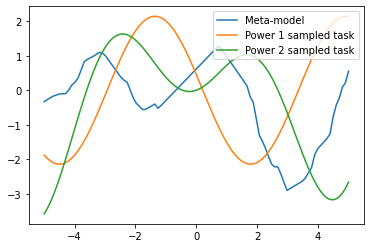

In [48]:
x = torch.linspace(-5,5).cuda()
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Power 1 sampled task")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Power 2 sampled task")

plt.legend(loc="upper right")
plt.show()

In [49]:
## Fine-tuning

# Sample a task

#testing_task = dist.sample_task()
#print("Sample task has amplitude",testing_task.amplitude,"and phase",testing_task.phase)

x_train,y_train = testing_task1.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model1.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model1(x_train)

  loss = criterion(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step == 1:
    fine_tuned_once_model1 = copy.deepcopy(saved_model)
  if step == 5:
    fine_tuned_five_model1 = copy.deepcopy(saved_model)

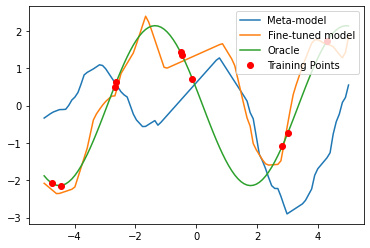

In [50]:
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output1 = [fine_tuned_once_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output2 = [fine_tuned_five_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output3 = [fine_tuned_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
#plt.plot(x.cpu(),output1,label="Fine-tuned once")
#plt.plot(x.cpu(),output2,label="Fine-tuned five")
plt.plot(x.cpu(),output3,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Oracle")

plt.plot(x_train.cpu(),y_train.cpu(),'ro',label="Training Points")

plt.legend(loc="upper right")
plt.show()

In [51]:
## Fine-tuning

# Sample a task

#testing_task = dist.sample_task()
#print("Sample task has amplitude",testing_task.amplitude,"and phase",testing_task.phase)

x_train,y_train = testing_task2.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model2.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model2(x_train)

  loss = criterion(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step == 1:
    fine_tuned_once_model2 = copy.deepcopy(saved_model)
  if step == 5:
    fine_tuned_five_model2 = copy.deepcopy(saved_model)

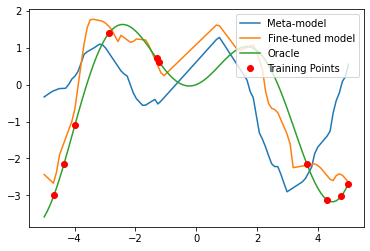

In [52]:
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output1 = [fine_tuned_once_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
#output2 = [fine_tuned_five_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output3 = [fine_tuned_model2(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
#plt.plot(x.cpu(),output1,label="Fine-tuned once")
#plt.plot(x.cpu(),output2,label="Fine-tuned five")
plt.plot(x.cpu(),output3,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle")

plt.plot(x_train.cpu(),y_train.cpu(),'ro',label="Training Points")

plt.legend(loc="upper right")
plt.show()